# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
import pandas as pd 
import numpy as np 
from tqdm import tqdm
import nltk 
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords 
from sklearn.feature_extraction.text import TfidfVectorizer 
import spacy
import re
%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import catboost as cb
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestClassifier

In [2]:
#загружаем данные
data=pd.read_csv('/datasets/toxic_comments.csv', index_col=0)


In [3]:
#посмотрим, что у нас с данными
data.shape
data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


In [4]:
data.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [5]:
#объявим корпус
corpus = data['text'].values
print(corpus[0])

Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27


In [6]:
nlp = spacy.load('en_core_web_sm')
regex = re.compile(r'[^a-zA-Z]')

def lemmatize_and_clear_text(text):
    doc = nlp(text)
    lem_text = [token.lemma_.lower() for token in doc if token.is_alpha]
    text_out = ' '.join(lem_text)
    text_out = regex.sub(' ', text_out)
    return text_out

In [7]:

nltk.download('wordnet')
nltk.download('stopwords')

# подключаем английский лемматизатор
lemmatizer = WordNetLemmatizer()

# подключаем стоп-слова из библиотеки NLTK
nltk_stopwords = set(stopwords.words('english'))

# подключаем английский модуль SpaCy
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# создаем функцию для лемматизации и очистки текста от стоп-слов
def preprocess(text):
    # разбиваем текст на токены с помощью SpaCy
    doc = nlp(text.lower())
    # лемматизируем каждый токен с помощью NLTK лемматизатора
    tokens = [lemmatizer.lemmatize(token.text) for token in doc]
    # удаляем стоп-слова
    tokens = [token for token in tokens if token not in nltk_stopwords]
    # объединяем токены обратно в текст
    return ' '.join(tokens)


[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
for i in tqdm(range(len(corpus))):
    corpus[i] = preprocess(corpus[i])

100%|██████████| 159292/159292 [23:57<00:00, 110.84it/s] 


0    143106
1     16186
Name: toxic, dtype: int64


<AxesSubplot:xlabel='toxic', ylabel='count'>

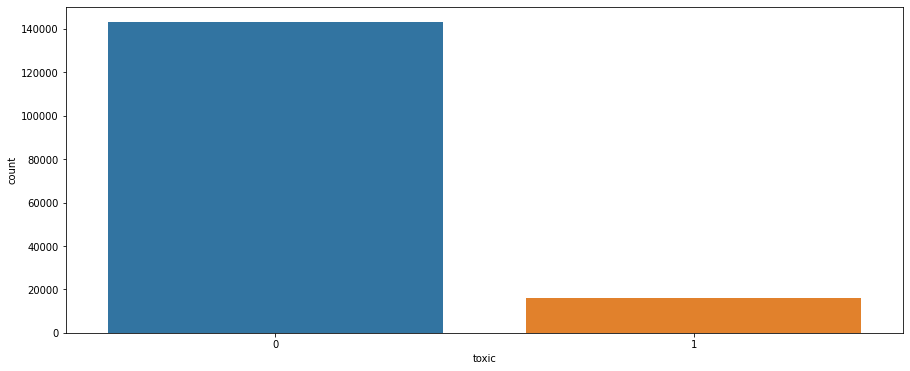

In [13]:
#посмотрим как классы выглядят на графике
print(data['toxic'].value_counts())
zeroes = data['toxic'].value_counts()[0]
ones = data['toxic'].value_counts()[1]

plt.figure(figsize=(15, 6))
sns.countplot(x='toxic', data=data)

In [27]:

#проверим как выглядит лемматизированный текст
data['lemm_text'].tail(20)

KeyError: 'lemm_text'

In [15]:
#Определяем признаки, делим на выборки
features = data['text']
target = data['toxic']

features_train_1, features_test_1, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=42, stratify = target)

In [16]:
#try:
#    nltk.download('stopwords')
#except:
#    pass
#Объявляем набор стоп-слов 
#try:
#    stopwords = set(stopwords.words('english'))
#except:
#    pass
#TFIDF-векторизатор
count_tf_idf = TfidfVectorizer() 
#Векторизация текстов
features_train = count_tf_idf.fit_transform(features_train_1)
features_test = count_tf_idf.transform(features_test_1)

In [17]:
print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

(119469, 150672)
(39823, 150672)
(119469,)
(39823,)


На первом этапе произведена загрузка данных и их подготовка для обучения моделей. Для анализа данных и построения модели предоставлен датасет с размеченными данными, содержащий комментарии пользователей к товарам, доступным для приобретения в интернет-магазине «Викишоп». Датасет состоит из 2 столбцов с данными и 159291 строки. 
Столбцы:
text — текст комментария;
toxic — является ли комментарий токсичным.

Пропуски в данных отсутствуют, ими мы не занимались, дубликаты тоже не смотрели.

Далее мы объявили корпус текстов и перевели в тип юникод. Тексты  очищены и лемматизированы. 
Для векторизации текстов был использован TfidfVectorizer(). Датасет разделили на обучающую и тестовые выборки в соотношении 4:1. 

## Обучение

В качестве моделей будем использовать Логистическую регрессию и Случайный лес 
CatBoost классификатор оставим на сладкое, пока он закомментирован


In [18]:
#cоздадим константную модель для проверки
const_model = [1 for i in range(len(target_test))]
const_f1 = f1_score(target_test.reset_index(drop=True), const_model)
print(const_f1)

0.18445827349609065


In [19]:
%%time
#Обучаем Логистическую регрессию
regression = LogisticRegression(fit_intercept=True, 
                                class_weight='balanced', 
                                random_state=42,
                                solver='liblinear'
                               )
#Определяем словарь с набором гиперпараметров
regression_parametrs = {'C': [10, 12]}

#GridSearchCV 

regression_grid = GridSearchCV(regression, regression_parametrs, scoring='f1', cv=3)
regression_grid.fit(features_train, target_train)

regression_grid.best_score_

CPU times: user 54.6 s, sys: 1min 38s, total: 2min 32s
Wall time: 2min 32s


0.7626255016234743

In [20]:
#определяем гиперпараметры

regression_params = regression_grid.best_params_
regression_score = regression_grid.score(features_train, target_train)
print(regression_params)
print(regression_score)
print('_______________')

{'C': 10}
0.9164328505346174
_______________


Переходим к модели Случайный лес

In [25]:
%%time
#Подбираем  гиперпараметры 
forest = RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1)
#Определяем словарь 
forest_parametrs = { 'n_estimators': range(38, 40, 5),
                     'max_depth': range(6, 8, 2)}

#GridSearchCV
forest_grid = GridSearchCV(forest, forest_parametrs, scoring='f1', cv=3)
forest_grid.fit(features_train, target_train)

forest_grid.best_score_

CPU times: user 12.9 s, sys: 102 ms, total: 13 s
Wall time: 13 s


0.3116000328981014

Теперь пройдемся CatBoost - по Кошачьему Бусту не пойдем. Все падает, а локально пока нет возможноси выполнить. В чатике рекомендуют уменьшить выборку.

К тому же, нет требований по конкретным моделям.
Вообще, есть ли ресурсы, где расписана хорошая таблица рекомендаций по применимости разных моделей в конкретных условиях?

In [23]:

#пройдемся по тестовой выборке в лучшей модели
regression_model = LogisticRegression(fit_intercept=True,
                                class_weight='balanced',
                                random_state=42,
                                solver='liblinear',
                                C=10)
regression_model.fit(features_train, target_train)


regression_model_predictions = regression_model.predict(features_test)
#смотрим, что у нас с f1

#42 - это ответ на главный вопрос о жизни

In [24]:
regression_predictions = regression_model.predict(features_test)
regression_f1 = round(f1_score(target_test, regression_predictions), 3) 
print(regression_f1)

0.76


## Выводы

На первом этапе произведена загрузка, анализ и подготовка данных для обучения моделей. 

На этапе обучения в качестве моделей использованы Логистическая регрессия, Случайный лес 
По результатам подбора гиперпараметров и обучения моделей лучший результат у Логистической регресиия, худший - Случайный лес. Все выбранные модели прошли проверку в сравнении с константной моделью. Полученные результаты сведены в таблицу. 
Можно рекомендовать использование модели Логистической регрессии для решения поставленной задачи, так как результат 0,76 отвечает поставленным требованиям, и, следовательно, модель Логистической регрессии способна классифицировать комментарии на позитивные и негативные и ее можно использовать в работе интернет-магазина «Викишоп» 



PS Для ревьювера, не заказчика
До BERT я не дошел, хочется отдохнуть, как-то слишком плотно идет обучения, но я вернусь к нему. Думаю, можно получить гораздо более интересные результаты. Но есть и вопрос дополнительный: если есть показатель, при котором заказ должны принать, например
0.75. В результате работы я получаю 0.76, стоит ли искать еще лучший вариант?) По опыту, лучшее - враг хорошего?
